In [1]:
import numpy as np
from ase import io

In [2]:
from toolbox.calculator.elecpot import WannierHartreePotentialCalculator
from toolbox.utils.unit import AU_TO_ANG

In [3]:
def read_wannier_spread(fname: str):
    with open(fname, "r") as f:
        lines = f.readlines()[2:-1]
    spread = np.array([float(line.split()[-1]) for line in lines])
    return spread

In [4]:
# Wannier spread [Bohr^2]
all_spread = read_wannier_spread("wannier_spread.out")
spread = all_spread.mean()

atoms = io.read("coord.xyz")
dx = 1e-3
l_box = atoms.cell.cellpar()[2]
grids = np.arange(0.0, l_box, dx)
cross_area = np.linalg.norm(np.cross(atoms.cell[0], atoms.cell[1]))

obj_ave_mlwc = WannierHartreePotentialCalculator(
    grids=grids,
    l_box=l_box,
    cross_area=cross_area,
    spread_dict={
        "O": 0.244554 * AU_TO_ANG,
        "H": 0.200000 * AU_TO_ANG,
        "X": np.sqrt(spread / 3) * AU_TO_ANG,
    },
    charge_dict={"O": 6.0, "H": 1.0, "X": -2.0},
)
phi_ave_mlwc = obj_ave_mlwc.run(dname="./")

| | FFT took 0.004458000000000517 s
| | k-space arithmetics took 0.0008509999999999351 s
| | Inverse FFT took 0.0032969999999998834 s


In [5]:
obj_mlwc = WannierHartreePotentialCalculator(
    grids=grids,
    l_box=l_box,
    cross_area=cross_area,
    charge_dict={"O": 6.0, "H": 1.0, "X": -2.0},
)
spread = np.zeros(len(atoms))
spread[atoms.symbols == "O"] = 0.244554 * AU_TO_ANG
spread[atoms.symbols == "H"] = 0.200000 * AU_TO_ANG
spread = np.concatenate([spread, np.sqrt(all_spread / 3) * AU_TO_ANG])
phi_mlwc = obj_mlwc.run(spread=spread, dname="./")

In [ ]:
from matplotlib import pyplot as plt

from toolbox.io.cp2k import Cp2kHartreeCube
from toolbox import plot

plot.use_style("pub")

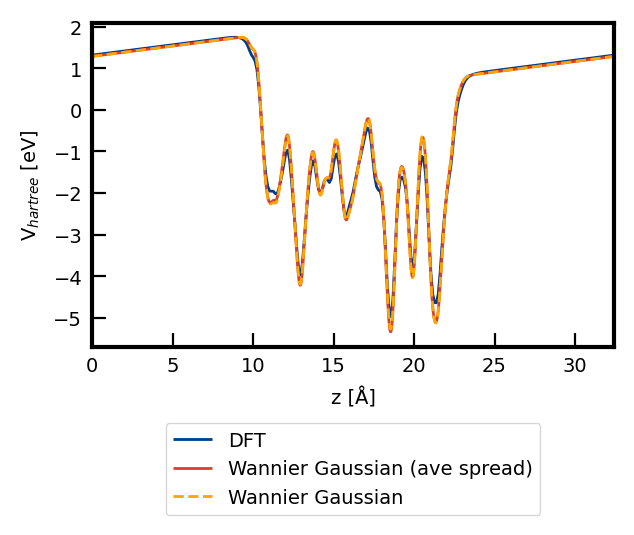

In [ ]:
fig, ax = plt.subplots(figsize=[3, 2])

cube = Cp2kHartreeCube("cp2k-v_hartree-1_0.cube")
out = cube.get_ave_cube()
ax.plot(out[0], out[1], color="blue", label="DFT")

ax.plot(grids, phi_ave_mlwc, color="red", label="Wannier Gaussian (ave spread)")
ax.plot(grids, phi_mlwc, "--", color="orange", label="Wannier Gaussian")

plot.ax_setlabel(ax, "z [Å]", r"V$_{hartree}$ [eV]")
ax.set_xlim(0.0, l_box)

ax.legend(bbox_to_anchor=(0.5, -0.55), loc="lower center")

plt.show()